In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_dir = "/content/gdrive/My Drive/MachineLearning/PlantIll/"
base_dir = root_dir + 'DPModel'

In [0]:
!pip install -q torch==1.0.0 torchvision

In [0]:
from fastai import *
from fastai.vision import *
from fastai.widgets import *
import torchvision.models as TorchModels


In [0]:
%reload_ext autoreload 
%autoreload 2
%matplotlib inline 

In [0]:
#change directory to where we have our project
import os 
os.getcwd() 
os.chdir('/content/gdrive/My Drive/MachineLearning/PlantIll') 

# Getting the data

In [0]:
## our datapath
path = Path('/content/gdrive/My Drive/Datasets/PlantVillage')
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [13]:
path.ls()

[PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/val'),
 PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/train'),
 PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/models')]

In [0]:
##### Data **augmentation** 
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src  = ImageList.from_folder(path)

In [16]:
src.items[0]

PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/val/Apple___Cedar_apple_rust/7e32ce27-bc89-4fca-9f49-c50de91210d1___FREC_C.Rust 4425.JPG')

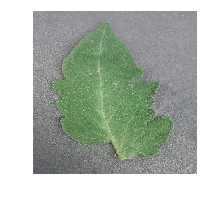

In [17]:
src[110].show()

In [18]:
sd = (src.split_by_folder(train='train', valid='val'))
sd

ItemLists;

Train: ImageList (26022 items)
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /content/gdrive/My Drive/Datasets/PlantVillage;

Valid: ImageList (6463 items)
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /content/gdrive/My Drive/Datasets/PlantVillage;

Test: None

In [19]:
labellists =(sd.label_from_folder())
labellists

LabelLists;

Train: LabelList (26022 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Potato___Late_blight,Potato___Late_blight,Potato___Late_blight,Potato___Late_blight,Potato___Late_blight
Path: /content/gdrive/My Drive/Datasets/PlantVillage;

Valid: LabelList (6463 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Apple___Cedar_apple_rust,Apple___Cedar_apple_rust,Apple___Cedar_apple_rust,Apple___Cedar_apple_rust,Apple___Cedar_apple_rust
Path: /content/gdrive/My Drive/Datasets/PlantVillage;

Test: None

In [0]:
##batch size 
bs= 128
## we will use it in progrissive resizing at the beggining it was 256//2
img_size = 256//2

In [0]:
labellists = (labellists.transform(tfms , size=img_size))

In [0]:
## our data bunch, it contains ou data loaders 
data =  labellists.databunch(bs=bs).normalize(imagenet_stats)

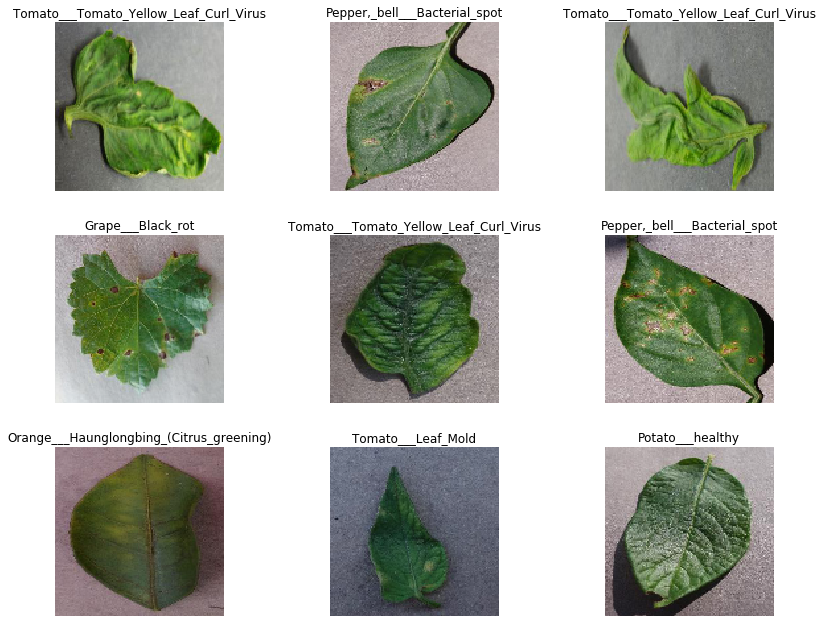

In [23]:
data.show_batch(rows=3, figsize=(12,9))

In [13]:
print(data.classes)
len(data.classes),data.c

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

(39, 39)

# Our Model 

In [0]:
inceptionModel = TorchModels.inception_v3(pretrained=True)
nf = data.c # number of output classes in your data
inceptionModel.fc = nn.Linear(in_features=2048, out_features=nf)

In [0]:
inceptionModel.AuxLogits.fc = nn.Linear(768, nf)
inceptionModel.fc = nn.Linear(2048, nf)

In [38]:
## fbeta is F1 score fbeta,
learn = cnn_learner(data,inceptionModel, metrics=accuracy)

TypeError: ignored

beta determines the value of the fbeta applied, eps is there for numeric stability. If sigmoid=True, a sigmoid is applied to the predictions before comparing them to thresh then to the targets. See the https://en.wikipedia.org/wiki/F1_score for details on the fbeta score.

In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time


# Train the model

In [0]:
learn.fit_one_cycle(7, max_lr=slice(1e-3, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.662495,0.637442,0.857342,1:11:03
1,2.314743,2.366043,0.847439,03:22
2,1.863870,1.591710,0.880551,03:21
3,1.378102,0.656018,0.934396,03:19
4,0.663677,0.269562,0.960854,03:26
5,0.244655,0.250835,0.976017,03:28
6,0.151511,0.082414,0.979731,03:26


In [0]:
learn.save('weight-resnet18-1')

Plotting Losses


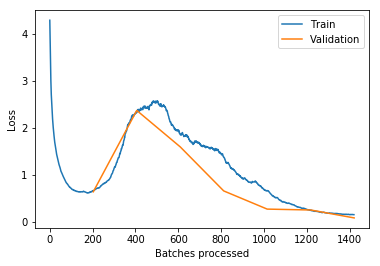

In [0]:
print("Plotting Losses")
learn.recorder.plot_losses()


Plotting metrics


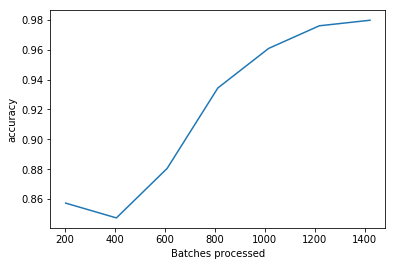

In [0]:
print("Plotting metrics")
learn.recorder.plot_metrics()


Plotting LR


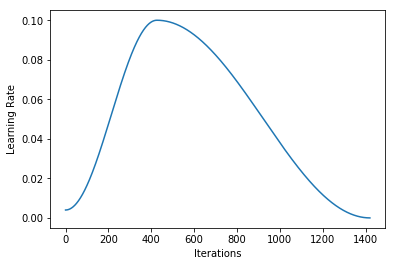

In [0]:
print("Plotting LR")
learn.recorder.plot_lr()

In [0]:
learn.load('weight-resnet18-1');

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(7, max_lr=slice(1e-3, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.776059,2.614008,0.647223,2:22:04
1,2.063881,10.861866,0.696271,03:40
2,1.543622,7.568786,0.834752,03:33
3,1.291537,2.669109,0.895095,03:33
4,0.423346,0.556994,0.957141,03:31
5,0.158675,0.067876,0.978802,03:30
6,0.088847,0.055299,0.984527,03:31


In [0]:
#learn.save('weight-resnet18-2')

In [0]:
learn.load('weight-resnet18-2');

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(7, max_lr=slice(1e-3, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.281662,5.681834,0.935479,06:32
1,2.303009,9871.534180,0.836763,06:25
2,1.764469,1.969702,0.914900,06:27
3,1.093987,0.795916,0.955439,06:25
4,0.525505,0.401996,0.971530,06:22
5,0.223267,3.681927,0.983444,06:21
6,0.135222,0.192630,0.985765,06:25


In [0]:
#learn.save('weight-resnet18-3')

In [0]:
learn.load('weight-resnet18-3');

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(7, max_lr=slice(1e-3, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.313674,0.402392,0.964103,06:28
1,2.028915,3.025635,0.915829,06:32
2,1.808272,0.890463,0.963330,06:29
3,1.124215,0.774841,0.968900,06:31
4,0.580554,0.421750,0.977719,06:32
5,0.270765,0.216157,0.984837,06:30
6,0.130163,0.182911,0.987931,06:30


In [0]:
#learn.save('weight-resnet18-4')

In [0]:
learn.load('weight-resnet18-4');

In [0]:
learn.unfreeze()
learn.fit_one_cycle(7, max_lr=slice(1e-3, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.501390,0.891880,0.942906,06:47
1,2.837861,2.417360,0.894786,06:50
2,1.739413,19.453203,0.924029,06:51
3,1.127085,5.571141,0.953118,06:48
4,0.555319,0.508348,0.968281,06:49
5,0.183427,0.099755,0.989633,06:48
6,0.095504,1.759296,0.990252,06:45


In [0]:
#learn.save('weight-resnet18-5')